In [1]:
# Udemy course: TensroFlow Developer certificate in 2023: Zero to Mastery Section 8


# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

# Unzip the downloaded file
import zipfile
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"


--2024-01-02 09:56:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0b::cf, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  69.6MB/s    in 16s     

2024-01-02 09:56:30 (98.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [2]:
# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [3]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/scallops'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheese_plate'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/filet_mignon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hot_and_sour_soup'.
There are 0 directories and 75 images i

# 75 images of each class on the traindataset
# 250 images of each class on the testdataset

In [4]:

# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # not shuffling the test data for prediction

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning on 10% of 101 food classes


* Create a ModelCheckpoint callback to save progress during training

* Create a Data augmentation layer

* Build a headless (no top layers) EfficientNetB0 architecture (backbone)

* Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

* Compile the models (Categorical crossentropy as the loss function, Adam optimizer with the default settings, metrics: accuracy)

* Feature extract for 5 epochs validation on 15% of the test data.

In [5]:
# Create checkpoint callback to save model
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)


In [6]:

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# data augmentation layer
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False


16705208/16705208 [==============================] - 0s 0us/step


In [7]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [9]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data (15%)
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 170s 670ms/step - loss: 3.3717 - accuracy: 0.2686 - val_loss: 2.5247 - val_accuracy: 0.4266
Epoch 2/5
237/237 [==============================] - 111s 465ms/step - loss: 2.1983 - accuracy: 0.4983 - val_loss: 2.0714 - val_accuracy: 0.4944
Epoch 3/5
237/237 [==============================] - 99s 415ms/step - loss: 1.8218 - accuracy: 0.5698 - val_loss: 1.8893 - val_accuracy: 0.5212
Epoch 4/5
237/237 [==============================] - 81s 341ms/step - loss: 1.6015 - accuracy: 0.6131 - val_loss: 1.8113 - val_accuracy: 0.5262
Epoch 5/5
237/237 [==============================] - 73s 306ms/step - loss: 1.4441 - accuracy: 0.6465 - val_loss: 1.7574 - val_accuracy: 0.5432


In [10]:

# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 63s 80ms/step - loss: 1.5890 - accuracy: 0.5815


[1.588964581489563, 0.5814653635025024]

In [11]:
# Function to plot the validation and training data separately
import matplotlib.pyplot as plt


def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

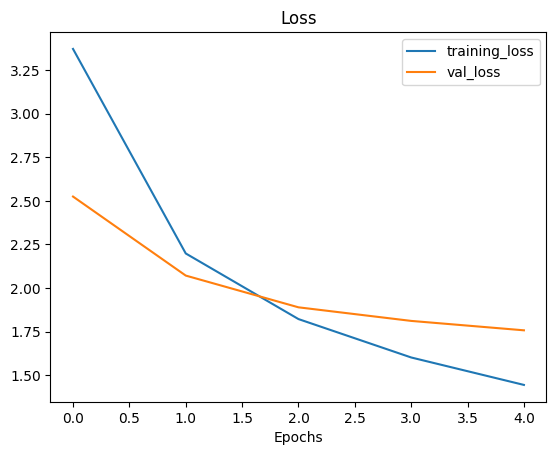

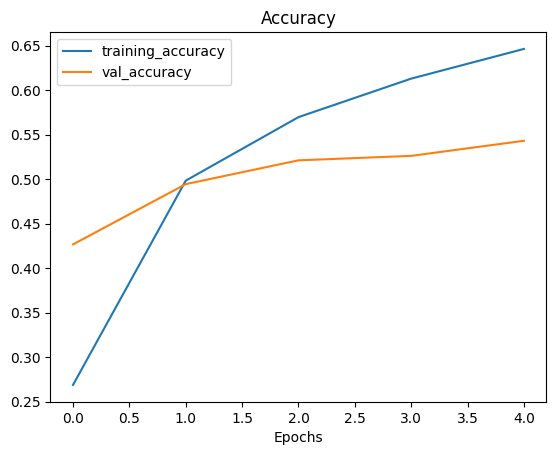

In [12]:

plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning (using the last 5 layers)

In [13]:

# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [14]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])


In [15]:

# What layers in the model are trainable?
# As long as any of the layers are trainable the block will show up as trainable (True)
for layer in model.layers:
  print(layer.name, layer.trainable)


input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [16]:

# Exactly which layers are trainable on the base_model (should be the last 5)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)


0 input_2 False
1 rescaling_2 False
2 normalization_1 False
3 rescaling_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [17]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, the total number of epochs will be 10 (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch (during the feature extraction mode)


Epoch 5/10
237/237 [==============================] - 90s 341ms/step - loss: 1.2103 - accuracy: 0.6809 - val_loss: 1.7158 - val_accuracy: 0.5477
Epoch 6/10
237/237 [==============================] - 72s 300ms/step - loss: 1.0880 - accuracy: 0.7075 - val_loss: 1.7357 - val_accuracy: 0.5450
Epoch 7/10
237/237 [==============================] - 65s 269ms/step - loss: 1.0090 - accuracy: 0.7299 - val_loss: 1.7040 - val_accuracy: 0.5532
Epoch 8/10
237/237 [==============================] - 60s 252ms/step - loss: 0.9348 - accuracy: 0.7506 - val_loss: 1.6896 - val_accuracy: 0.5596
Epoch 9/10
237/237 [==============================] - 63s 262ms/step - loss: 0.8920 - accuracy: 0.7592 - val_loss: 1.7034 - val_accuracy: 0.5548
Epoch 10/10
237/237 [==============================] - 62s 262ms/step - loss: 0.8295 - accuracy: 0.7811 - val_loss: 1.7312 - val_accuracy: 0.5482


In [18]:

# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 64s 81ms/step - loss: 1.5132 - accuracy: 0.5997


[1.51320481300354, 0.5997227430343628]

In [19]:
# define a function to compare 2 model history objects

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.

    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here)
    """

    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


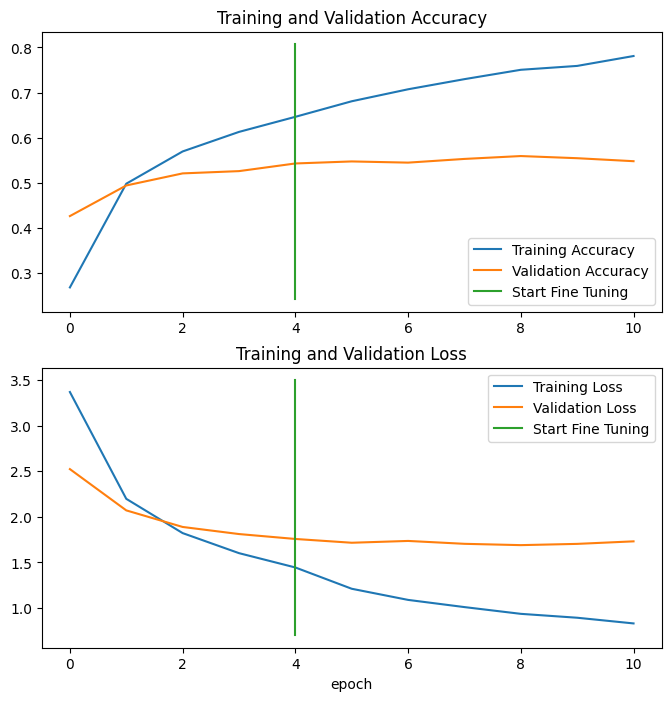

In [20]:

compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)


In [21]:
# The model is starting to overfit

In [22]:

# Save model
model.save("drive/My Drive/Colab Notebooks/101_food_class_10_percent_saved_big_dog_model")

In [23]:
# Load Model
loaded_model = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/101_food_class_10_percent_saved_big_dog_model")

In [24]:
# Check the loaded model
loaded_loss, loaded_accuracy = loaded_model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 64s 78ms/step - loss: 1.5132 - accuracy: 0.5997


(1.51320481300354, 0.5997227430343628)

In [25]:
# the same as prior to saving

## Evaluate the performance of the model across the different classes

## Make Predictions with the trained model

In [26]:

# Make predictions with model
pred_probs = model.predict(test_data, verbose=1) # the test images have to be exactly the same format as the the model was trained on

790/790 [==============================] - 66s 81ms/step


In [27]:
len(pred_probs)

25250

In [28]:
pred_probs.shape

(25250, 101)

In [29]:
# One prediction per class
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.64905918e-01 2.54100014e-04 1.41748548e-01 7.05127903e-08
 1.10836081e-05 5.79021571e-06 7.65001678e-05 6.96609322e-06
 1.87234990e-02 2.46787007e-04 1.11791428e-06 9.03748514e-06
 1.00810884e-03 2.26913258e-07 4.86396626e-03 5.64905163e-03
 1.94671102e-05 1.01426314e-03 4.67031589e-03 2.45464798e-05
 8.56261293e-04 6.55050735e-06 2.08253157e-04 1.24981554e-04
 5.53932099e-04 2.64582201e-03 1.60374248e-03 1.55558082e-04
 8.37537572e-02 1.87395851e-03 2.20724542e-06 1.93234754e-03
 3.59532132e-04 5.37866640e-07 9.06645693e-03 2.74697186e-06
 5.08603734e-05 2.29258463e-03 1.63354743e-02 5.35809086e-05
 3.12732067e-04 8.83943867e-03 9.08359711e-04 7.59805516e-06
 1.95346744e-04 8.07685356e-05 1.33929856e-03 4.46644728e-04
 4.45744899e-06 5.68556301e-02 1.44290650e-04 1.00494864e-04
 3.08834650e-02 3.33935469e-02 5.86378228e-05 2.22839857e-03
 1.07438928e-02 9.10956238e-04 1.19412108e-

In [30]:
# Get the class predicitons
pred_classes = pred_probs.argmax(axis=1)

# How do they look for the first 10?
pred_classes[:10]

array([ 0,  0,  0,  8,  8, 78, 29,  0,  0,  0])

# Evaluating Model Predictions

In [32]:

# get the labels from the test_data. Will need to unravel the 790 batches
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check the initial labels

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score, classification_report
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5997227722772277

In [34]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.26      0.32      0.29       250
           1       0.52      0.74      0.61       250
           2       0.70      0.56      0.62       250
           3       0.86      0.56      0.67       250
           4       0.61      0.38      0.46       250
           5       0.48      0.35      0.40       250
           6       0.78      0.72      0.75       250
           7       0.82      0.76      0.79       250
           8       0.19      0.64      0.30       250
           9       0.46      0.62      0.53       250
          10       0.54      0.42      0.47       250
          11       0.79      0.60      0.68       250
          12       0.73      0.58      0.65       250
          13       0.58      0.50      0.54       250
          14       0.58      0.50      0.54       250
          15       0.33      0.48      0.39       250
          16       0.73      0.49      0.58       250
          17       0.41    

In [35]:
# Get a dictionary of the classification report to allow visualization
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.2572347266881029,
  'recall': 0.32,
  'f1-score': 0.28520499108734404,
  'support': 250},
 '1': {'precision': 0.5227272727272727,
  'recall': 0.736,
  'f1-score': 0.6112956810631229,
  'support': 250},
 '2': {'precision': 0.698019801980198,
  'recall': 0.564,
  'f1-score': 0.6238938053097346,
  'support': 250},
 '3': {'precision': 0.8580246913580247,
  'recall': 0.556,
  'f1-score': 0.6747572815533981,
  'support': 250},
 '4': {'precision': 0.6064516129032258,
  'recall': 0.376,
  'f1-score': 0.46419753086419757,
  'support': 250},
 '5': {'precision': 0.47540983606557374,
  'recall': 0.348,
  'f1-score': 0.4018475750577367,
  'support': 250},
 '6': {'precision': 0.776824034334764,
  'recall': 0.724,
  'f1-score': 0.7494824016563146,
  'support': 250},
 '7': {'precision': 0.8154506437768241,
  'recall': 0.76,
  'f1-score': 0.7867494824016563,
  'support': 250},
 '8': {'precision': 0.19184652278177458,
  'recall': 0.64,
  'f1-score': 0.2952029520295203,
  'support':

In [39]:


# Get the class names
class_names = test_data.class_names

# focus on the f1-scores to visualize how the model is performing
# The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.28520499108734404,
 'baby_back_ribs': 0.6112956810631229,
 'baklava': 0.6238938053097346,
 'beef_carpaccio': 0.6747572815533981,
 'beef_tartare': 0.46419753086419757,
 'beet_salad': 0.4018475750577367,
 'beignets': 0.7494824016563146,
 'bibimbap': 0.7867494824016563,
 'bread_pudding': 0.2952029520295203,
 'breakfast_burrito': 0.5290102389078499,
 'bruschetta': 0.4716553287981859,
 'caesar_salad': 0.680365296803653,
 'cannoli': 0.6458797327394209,
 'caprese_salad': 0.5376344086021505,
 'carrot_cake': 0.5367965367965367,
 'ceviche': 0.38961038961038963,
 'cheese_plate': 0.5837320574162679,
 'cheesecake': 0.4087301587301587,
 'chicken_curry': 0.49333333333333335,
 'chicken_quesadilla': 0.6310344827586207,
 'chicken_wings': 0.75146771037182,
 'chocolate_cake': 0.5581395348837209,
 'chocolate_mousse': 0.37294332723948814,
 'churros': 0.7305389221556886,
 'clam_chowder': 0.7463312368972747,
 'club_sandwich': 0.7037037037037037,
 'crab_cakes': 0.3844393592677346,
 'creme_brule

In [40]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33    edamame  0.968254
63   macarons  0.893617
69    oysters  0.877049
75        pho  0.867769
32  dumplings  0.837675

In [42]:
# the last classes (the ones with poorer f1-scores)
f1_scores.tail()

class_name  f1-score
77      pork_chop  0.308824
8   bread_pudding  0.295203
0       apple_pie  0.285205
93          steak  0.281407
39      foie_gras  0.245399

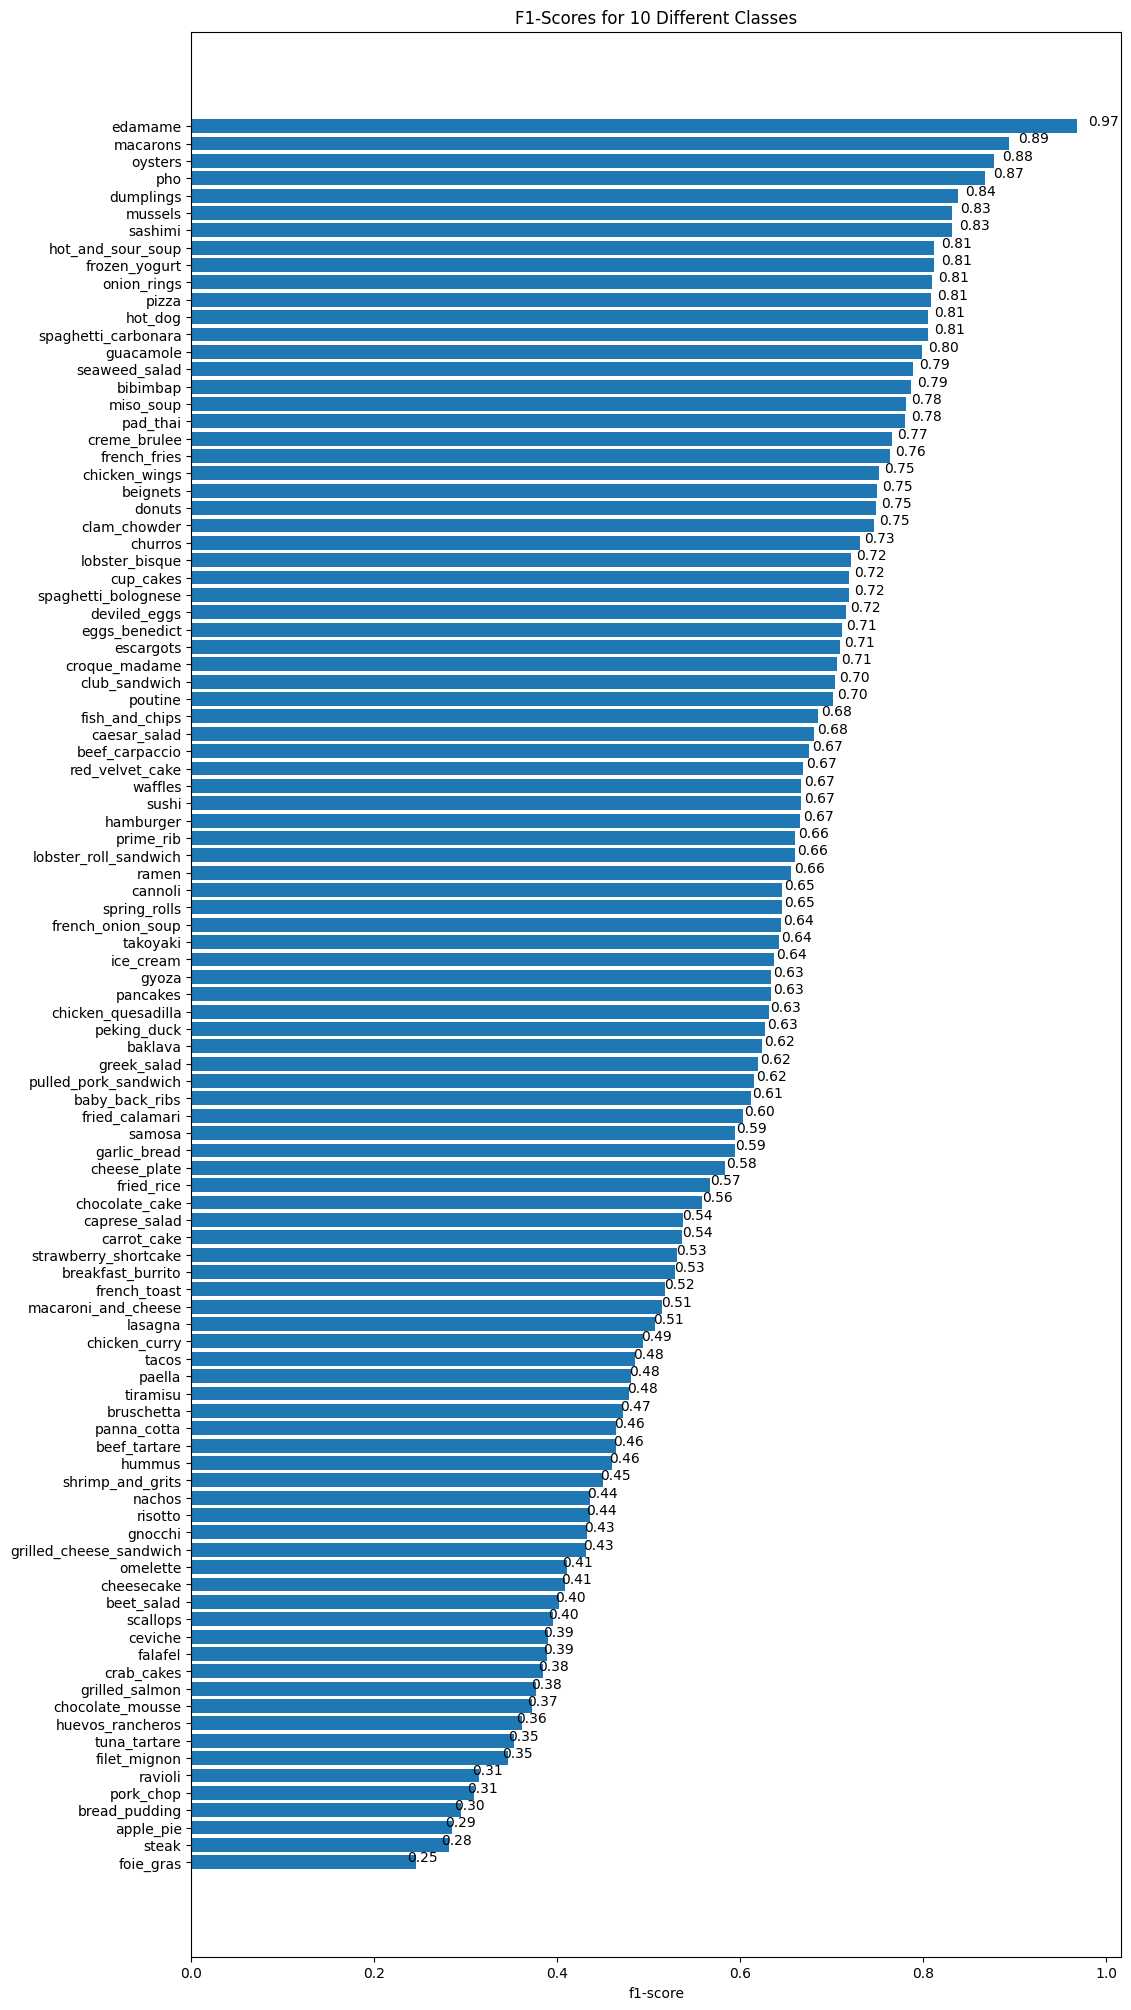

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

The model is doing well in some classes (top of the list) while on others like foie gras and steak is performing poorly

# Visualizing predictions on test images
first load an image to a tensor in order to be able to use the model

* Read in a target image filepath using tf.io.read_file().

* Turn the image into a Tensor using tf.io.decode_image().

* Resize the image to be the same size as the images the model has been trained on (224 x 224) using tf.image.resize().

* Scale the image to get all the pixel values between 0 & 1 if necessary (depending on the model used).

In [44]:

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  # will need to pass the information on whether the image needs to be scaled of not (3rd argument of the function)
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 26ms/step


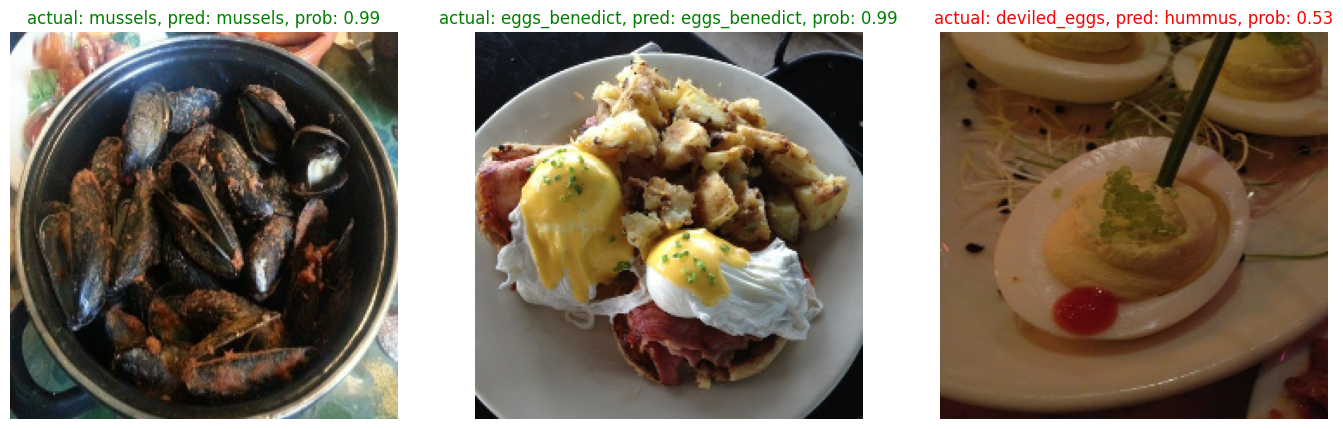

In [45]:

# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3): # look at 3 random images
  # Choose a random image from a random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # the base model is EfficientNet, no need to rescale the images for prediction
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]. After being loaded with load_and_prep function the image is already [224,224,3)]
  pred_class = class_names[pred_prob.argmax()] # get the predicted class

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # to help with the visualization change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


# Looking at wrong predictions

* Focus on wrong predictions with the highest prediction probability

In [47]:
# Get the filenames and paths of all the images in the test dataset
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [48]:

# to help with visualization create a dataframe witht he following information: filepath, true_label, predicted_label, prediction probability, the ground truth class name, and predicted class name.
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": pred_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df.head()


img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.464906        apple_pie        apple_pie  
1   0.974577        apple_pie        apple_pie  
2   0.739180        apple_pie        apple_pie  
3   0.295700        apple_pie    bread_pudding  
4   0.612727        apple_pie    bread_pudding

In [49]:
# add a column with the information on whether the prediction was correct (True) or not (False)
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.464906        apple_pie        apple_pie          True  
1   0.974577        apple_pie        apple_pie          True  
2   0.739180        apple_pie        apple_pie          True  
3   0.295700        apple_pie    bread_pudding         False  
4   0.612727        apple_pie    bread_pudding         False

In [50]:
# Find the top 100 wrong examples (the ones with the wrong label but the highest prediction probabilities)
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
191    b'101_food_classes_10_percent/test/apple_pie/3...       0      31   
10847  b'101_food_classes_10_percent/test/fried_calam...      43      68   
18001  b'101_food_classes_10_percent/test/pancakes/10...      72      67   
8794   b'101_food_classes_10_percent/test/escargots/1...      35      41   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
10346  b'101_food_classes_10_percent/test/french_onio...      41      54   
11642  b'101_food_classes_10_percent/test/garlic_brea...      46      10   
17855  b'101_food_classes_10_percent/test/paella/2314...      71      65   
7194   b'101_food_classes_10_percent/test/croque_mada...      28       7   
11146  b'101_food_classes_10_percent/test/fried_rice/...      44      62   
10741  b'101_food_classes_10_percent/test/french_toas...      42       1   
23631  b'101_food_classes_10_percent/test/strawberry_...      94      83   
23300  b'101_food_classes_10_percent/test/steak/17945...      93       1   
24479  b'101_food_classes_10_percent/test/takoyaki/68...      97      78   
5114   b'101_food_classes_10_percent/test/chicken_win...      20      38   
21810  b'101_food_classes_10_percent/test/scallops/17...      87      29   
9110   b'101_food_classes_10_percent/test/falafel/241...      36      31   
7295   b'101_food_classes_10_percent/test/cup_cakes/1...      29      31   
19430  b'101_food_classes_10_percent/test/pork_chop/3...      77       1   
22511  b'101_food_classes_10_percent/test/spaghetti_b...      90      78   

       pred_conf      y_true_classname     y_pred_classname  pred_correct  
191     0.998253             apple_pie               donuts         False  
10847   0.997576        fried_calamari          onion_rings         False  
18001   0.997399              pancakes             omelette         False  
8794    0.997039             escargots    french_onion_soup         False  
23797   0.996827                 sushi              sashimi         False  
10346   0.996667     french_onion_soup    hot_and_sour_soup         False  
11642   0.996660          garlic_bread           bruschetta         False  
17855   0.996031                paella              mussels         False  
7194    0.995488         croque_madame             bibimbap         False  
11146   0.995285            fried_rice  macaroni_and_cheese         False  
10741   0.995214          french_toast       baby_back_ribs         False  
23631   0.994853  strawberry_shortcake      red_velvet_cake         False  
23300   0.994327                 steak       baby_back_ribs         False  
24479   0.993391              takoyaki              poutine         False  
5114    0.992946         chicken_wings       fish_and_chips         False  
21810   0.992711              scallops            cup_cakes         False  
9110    0.992433               falafel               donuts         False  
7295    0.991986             cup_cakes               donuts         False  
19430   0.991815             pork_chop       baby_back_ribs         False  
22511   0.991675   spaghetti_bolognese              poutine         False

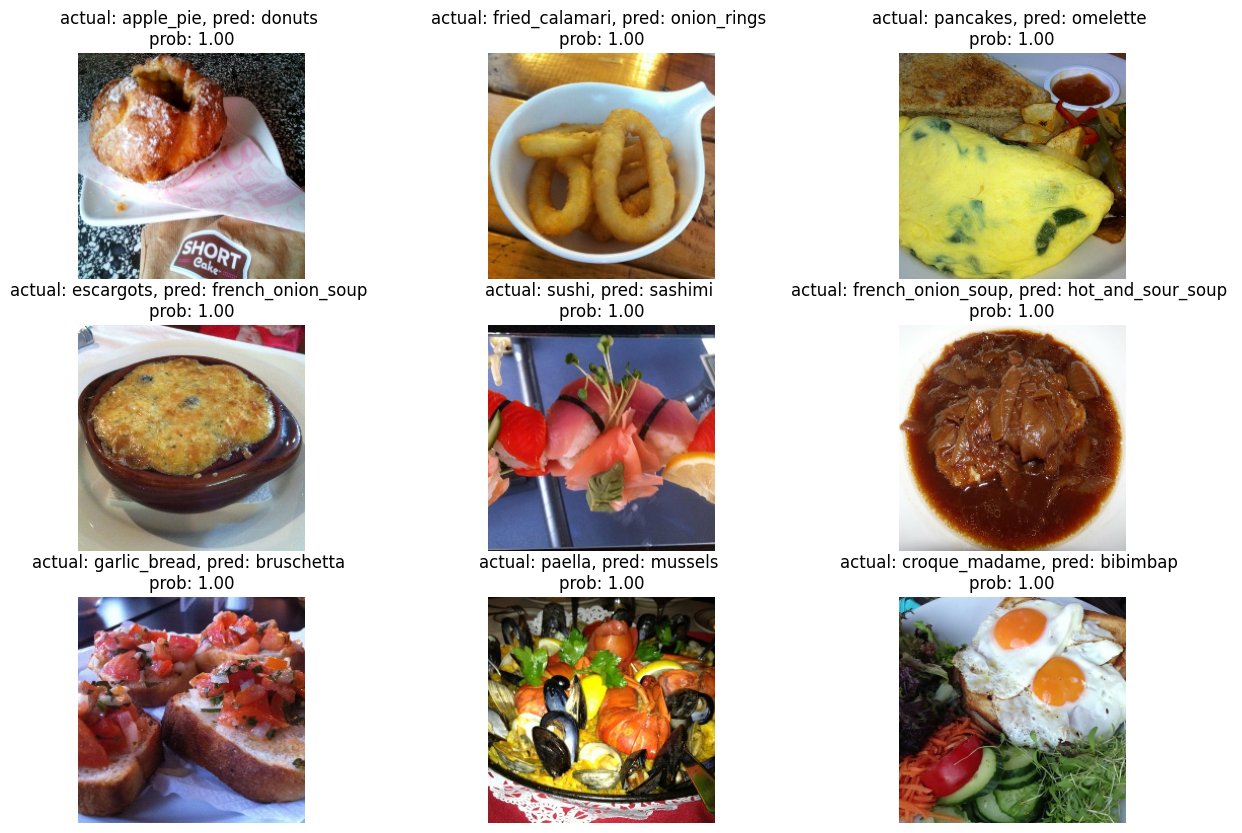

In [52]:
# Visualize 9 exaples
images_to_view = 9
start_index = 0 # start index, if 0 start at the beginning of the ordered dataframe from the previous cell
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

Observations:
 * Some labels appear to be wrong.
 * Some classes are recurrently poorly classified. If feasible it might be good to get more examples/data of those classes.


In [55]:
# Test the model on images that were not part of the model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

zip_ref = zipfile.ZipFile("custom_food_images.zip", "r")
zip_ref.extractall()
zip_ref.close()


# New images filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images


--2024-01-02 12:02:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2024-01-02 12:02:39 (105 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



['custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/pizza-dad.jpeg']

1/1 [==============================] - 0s 47ms/step


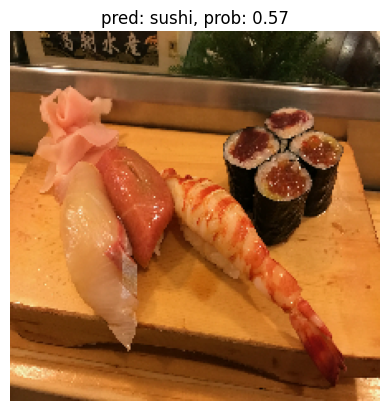

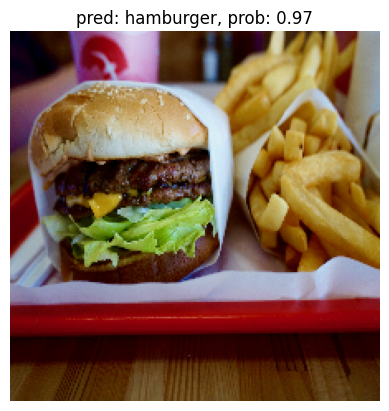

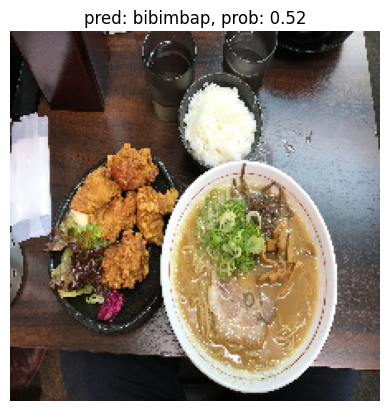

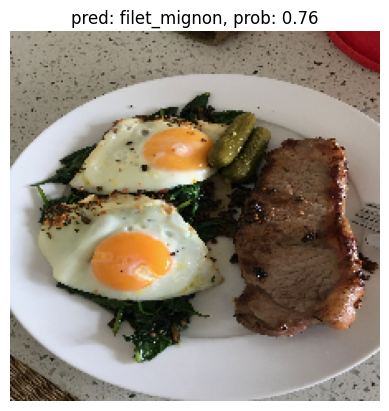

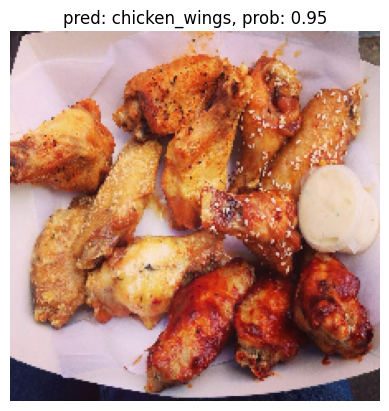

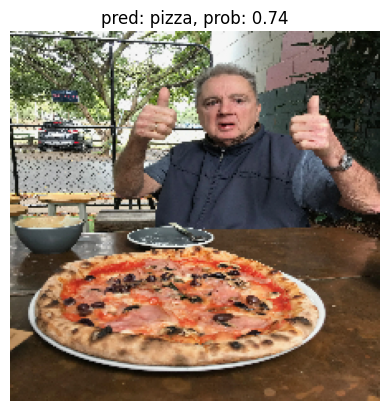

In [56]:

# Make predictions on the new custom images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor  of the "correct" size
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # get the predicted class label
  # Plot the image with the predicted class and predicted probability
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [57]:
# New images filepaths to be tested
custom_food_images_2 = ["/content/pizza_test.jpg", "/content/ramen_test.jpg", "/content/fish_and_chips_test.jpg","/content/carrot_cake_test.jpg", "/content/apple_pie_test.jpg",  ]
custom_food_images_2


['/content/pizza_test.jpg',
 '/content/ramen_test.jpg',
 '/content/fish_and_chips_test.jpg',
 '/content/carrot_cake_test.jpg',
 '/content/apple_pie_test.jpg']

1/1 [==============================] - 0s 48ms/step


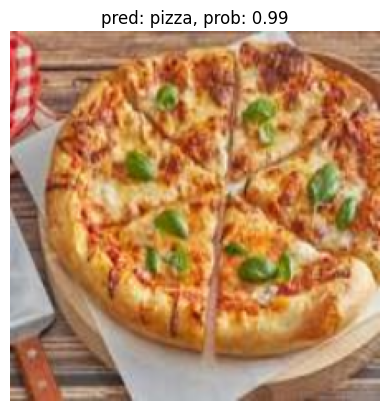

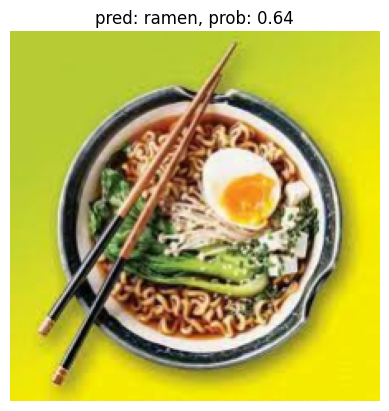

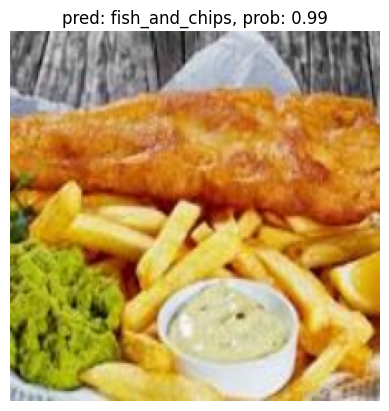

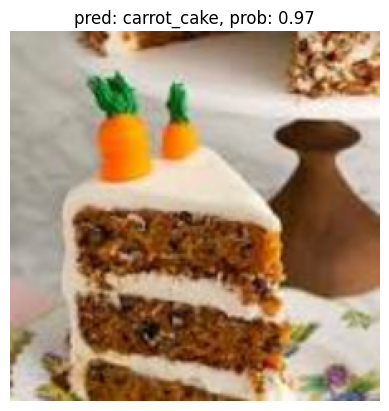

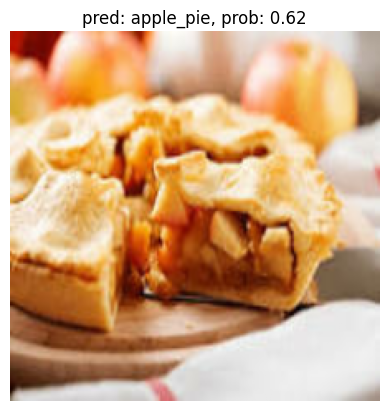

In [58]:
# Make predictions on the new set of images
for img in custom_food_images_2:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor  of the "correct" size
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # get the predicted class label
  # Plot the image with the predicted class and predicted probability
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)

In [59]:
# using clean/clear new images the model got all correct